# **Import Libraries & Setup**

In [1]:
# Import Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Scikit-learn (Preprocessing, Model, Evaluation)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, auc, make_scorer, 
    classification_report
)

# Statistical Test
from scipy.stats import chi2_contingency

# Optional
%matplotlib inline
sns.set(style="whitegrid")

# **Data Loading & Initial Inspection**

In [2]:
raw_data = 'https://raw.githubusercontent.com/vaterprawira/Dataset/refs/heads/main/loan_data.csv'
df = pd.read_csv(raw_data)

/tmp/ipykernel_122/3783602144.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(raw_data)


In [3]:
print("Preview Dataset")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df.head()

Preview Dataset


,loanId,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStatus,clientTimeAtEmployer,clientNumberPhoneContacts,clientAvgCallsPerDay,loanNumber,loanAmount,interestRate,loanTerm,maxAmountTaken,maxTenorTaken,settleDays,paymentRatio,firstPaymentDefault,loanDefault,loanIncomeRatio,applicationDateMonth,approvalDateMonth,disbursementDateMonth,repaidDateMonth,FirstPaymentDueDateMonth,dueDateMonth
0,PP99804128,66452.66,1,38,MALE,Married,education,Employer Provided,> 36 Months,458.000000,6.792453,1,42000,6.0,90,1,1,-9,0.0,0,0,0.632029,5,5,5,5,6,8
1,PP99781446,35000.00,1,35,MALE,Single,other,Rented,> 36 Months,708.000000,2.144928,1,20000,6.0,90,0,1,6,0.0,0,0,0.571429,5,5,5,6,6,8
2,PP99274960,162851.11,1,47,FEMALE,Married,education,Own Residence,> 36 Months,622.000000,36.095238,1,134000,6.0,90,0,1,23,0.0,1,0,0.822837,5,5,5,6,6,8
3,PP97847695,55053.68,1,33,MALE,Single,other,Own Residence,> 36 Months,1289.979347,53.845718,1,34500,6.0,90,1,1,-7,0.0,0,1,0.626661,5,5,5,5,6,8
4,PP97841916,32112.55,1,30,MALE,Single,house,Rented,> 36 Months,608.000000,85.528481,1,20000,6.0,90,1,1,19,0.0,1,0,0.622809,5,5,5,6,6,8


# **Exploratory Data Analysis (EDA)**

In [4]:
print("Dataset Information")
df.info()

Dataset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159596 entries, 0 to 159595
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loanId                     159596 non-null  object 
 1   clientIncome               159596 non-null  float64
 2   incomeVerified             159596 non-null  int64  
 3   clientAge                  159596 non-null  int64  
 4   clientGender               159596 non-null  object 
 5   clientMaritalStatus        159596 non-null  object 
 6   clientLoanPurpose          159596 non-null  object 
 7   clientResidentialStatus    159596 non-null  object 
 8   clientTimeAtEmployer       159596 non-null  object 
 9   clientNumberPhoneContacts  159596 non-null  float64
 10  clientAvgCallsPerDay       159596 non-null  float64
 11  loanNumber                 159596 non-null  int64  
 12  loanAmount                 159596 non-null  int64  
 13  interestR

In [5]:
print("Dataset Shape")
print(f"Number of rows  : {df.shape[0]:,}")
print(f"Number of column: {df.shape[1]:,}")

Dataset Shape
Number of rows  : 159,596
Number of column: 28


In [6]:
print("Missing Values Analysis")
missing_count = df.isnull().sum()
print(missing_count)

Missing Values Analysis
loanId                       0
clientIncome                 0
incomeVerified               0
clientAge                    0
clientGender                 0
clientMaritalStatus          0
clientLoanPurpose            0
clientResidentialStatus      0
clientTimeAtEmployer         0
clientNumberPhoneContacts    0
clientAvgCallsPerDay         0
loanNumber                   0
loanAmount                   0
interestRate                 0
loanTerm                     0
maxAmountTaken               0
maxTenorTaken                0
settleDays                   0
paymentRatio                 0
firstPaymentDefault          0
loanDefault                  0
loanIncomeRatio              0
applicationDateMonth         0
approvalDateMonth            0
disbursementDateMonth        0
repaidDateMonth              0
FirstPaymentDueDateMonth     0
dueDateMonth                 0
dtype: int64


In [7]:
print("Duplicate Data Analysis")
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Duplicate Data Analysis
Number of duplicate rows: 12


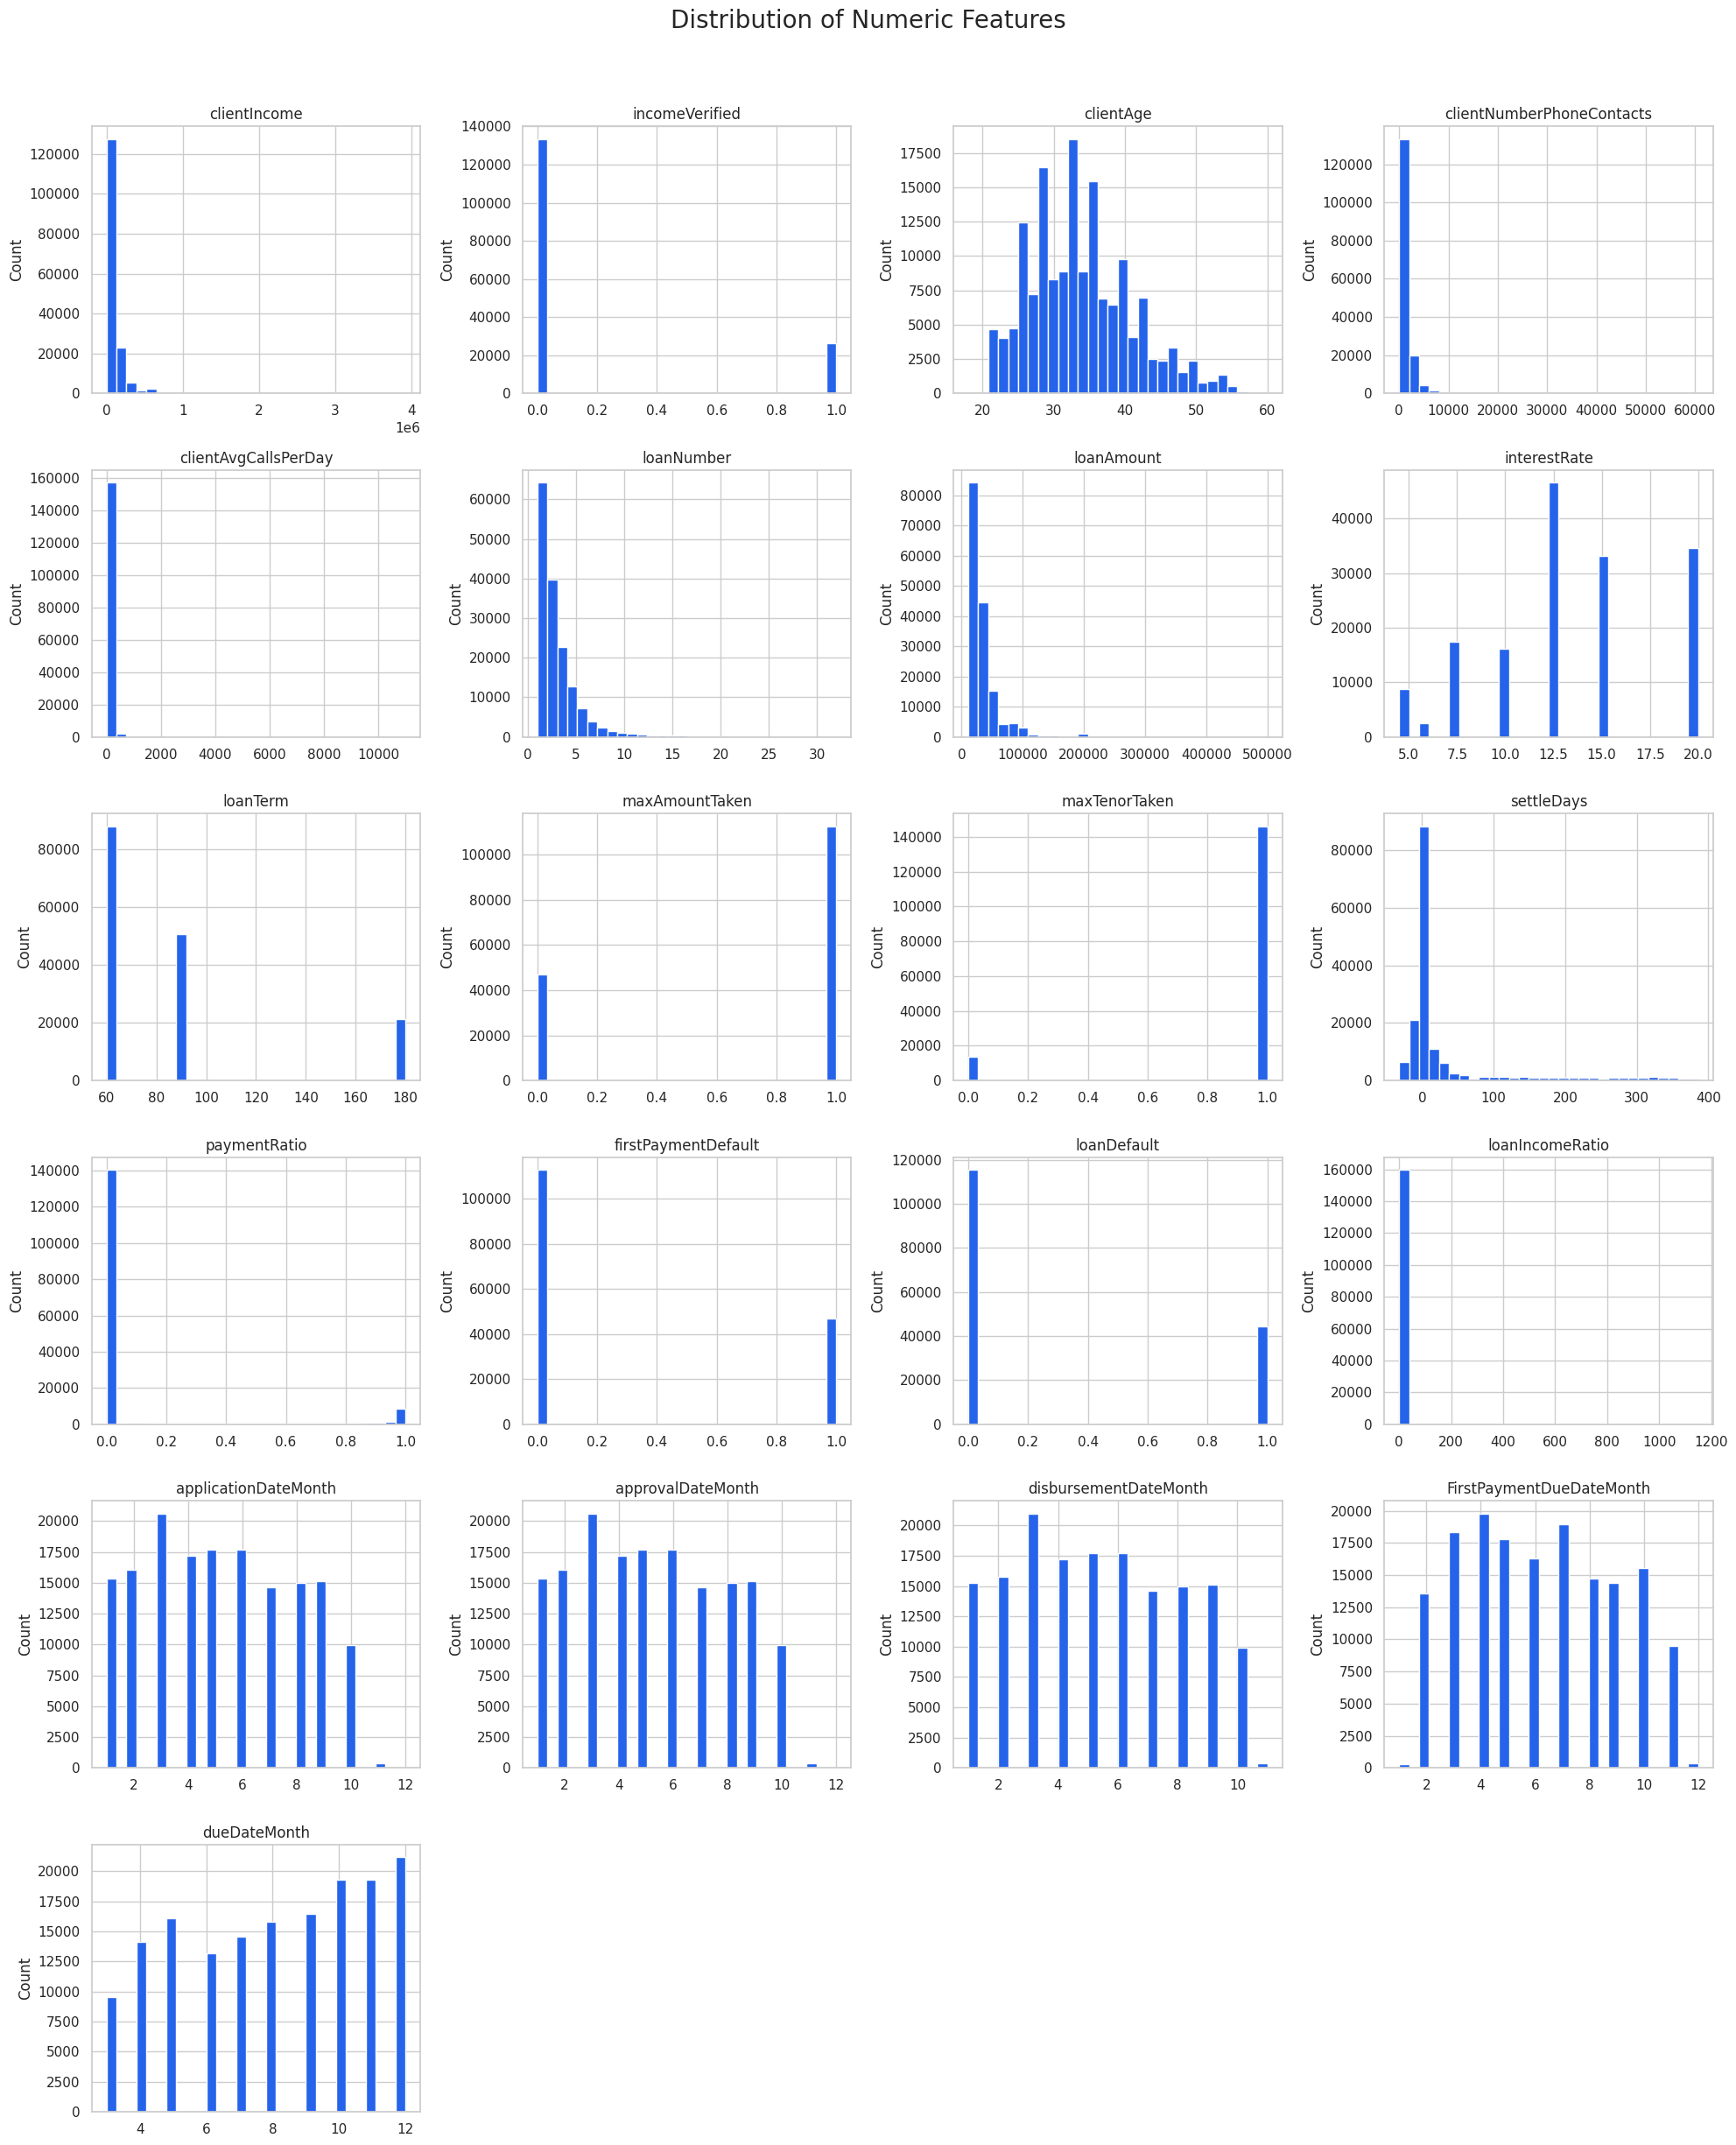

In [8]:
# Distribution of Numeric Features
def plot_all_numeric_histograms(df, cols_per_row=4):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    n = len(numeric_cols)
    rows = math.ceil(n / cols_per_row)

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5*cols_per_row, 4*rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        df[col].hist(bins=30, ax=axes[i], color='#2563EB')
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Count')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Distribution of Numeric Features", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

plot_all_numeric_histograms(df)

In [9]:
transform = ['incomeVerified', 'maxAmountTaken', 'maxTenorTaken', 'firstPaymentDefault']
df[transform] = df[transform].astype(bool)

df.head()

,loanId,clientIncome,incomeVerified,clientAge,clientGender,clientMaritalStatus,clientLoanPurpose,clientResidentialStatus,clientTimeAtEmployer,clientNumberPhoneContacts,clientAvgCallsPerDay,loanNumber,loanAmount,interestRate,loanTerm,maxAmountTaken,maxTenorTaken,settleDays,paymentRatio,firstPaymentDefault,loanDefault,loanIncomeRatio,applicationDateMonth,approvalDateMonth,disbursementDateMonth,repaidDateMonth,FirstPaymentDueDateMonth,dueDateMonth
0,PP99804128,66452.66,True,38,MALE,Married,education,Employer Provided,> 36 Months,458.000000,6.792453,1,42000,6.0,90,True,True,-9,0.0,False,0,0.632029,5,5,5,5,6,8
1,PP99781446,35000.00,True,35,MALE,Single,other,Rented,> 36 Months,708.000000,2.144928,1,20000,6.0,90,False,True,6,0.0,False,0,0.571429,5,5,5,6,6,8
2,PP99274960,162851.11,True,47,FEMALE,Married,education,Own Residence,> 36 Months,622.000000,36.095238,1,134000,6.0,90,False,True,23,0.0,True,0,0.822837,5,5,5,6,6,8
3,PP97847695,55053.68,True,33,MALE,Single,other,Own Residence,> 36 Months,1289.979347,53.845718,1,34500,6.0,90,True,True,-7,0.0,False,1,0.626661,5,5,5,5,6,8
4,PP97841916,32112.55,True,30,MALE,Single,house,Rented,> 36 Months,608.000000,85.528481,1,20000,6.0,90,True,True,19,0.0,True,0,0.622809,5,5,5,6,6,8


In [10]:
print("Column Data Types\n")
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numeric Columns ({len(numeric_cols)}): {numeric_cols}\n")
print(f"Categorical Columns ({len(categorical_cols)}): {categorical_cols}")

Column Data Types

Numeric Columns (17): ['clientIncome', 'clientAge', 'clientNumberPhoneContacts', 'clientAvgCallsPerDay', 'loanNumber', 'loanAmount', 'interestRate', 'loanTerm', 'settleDays', 'paymentRatio', 'loanDefault', 'loanIncomeRatio', 'applicationDateMonth', 'approvalDateMonth', 'disbursementDateMonth', 'FirstPaymentDueDateMonth', 'dueDateMonth']

Categorical Columns (11): ['loanId', 'incomeVerified', 'clientGender', 'clientMaritalStatus', 'clientLoanPurpose', 'clientResidentialStatus', 'clientTimeAtEmployer', 'maxAmountTaken', 'maxTenorTaken', 'firstPaymentDefault', 'repaidDateMonth']


In [11]:
print("Descriptive Statistics")
df[numeric_cols].describe()

Descriptive Statistics


,clientIncome,clientAge,clientNumberPhoneContacts,clientAvgCallsPerDay,loanNumber,loanAmount,interestRate,loanTerm,settleDays,paymentRatio,loanDefault,loanIncomeRatio,applicationDateMonth,approvalDateMonth,disbursementDateMonth,FirstPaymentDueDateMonth,dueDateMonth
count,1.595960e+05,159596.00000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000,159596.000000
mean,9.083906e+04,33.69122,1262.055414,59.157969,3.556806,35324.184190,13.331235,85.385599,32.602189,0.097991,0.277419,0.708746,5.228458,5.228464,5.230964,6.221572,8.026379
std,9.728033e+04,7.17613,1512.437702,101.213141,2.471578,27840.824297,4.467938,39.323756,84.552544,0.278058,0.447727,3.059205,2.737371,2.737374,2.734304,2.726173,2.835455
min,3.000000e+01,18.00000,0.000000,0.000000,1.000000,11000.000000,4.500000,60.000000,-32.000000,0.000000,0.000000,0.010675,1.000000,1.000000,1.000000,1.000000,3.000000
25%,3.500000e+04,28.00000,435.000000,10.050000,2.000000,20000.000000,10.000000,60.000000,-2.000000,0.000000,0.000000,0.285714,3.000000,3.000000,3.000000,4.000000,6.000000
50%,5.511621e+04,33.00000,842.000000,30.302387,3.000000,25500.000000,12.500000,60.000000,0.000000,0.000000,0.000000,0.505556,5.000000,5.000000,5.000000,6.000000,8.000000
75%,1.050000e+05,38.00000,1532.000000,70.027692,4.000000,37500.000000,15.000000,90.000000,13.000000,0.000000,1.000000,0.914286,8.000000,8.000000,8.000000,8.000000,11.000000
max,3.925000e+06,60.00000,60595.000000,10994.500000,32.000000,500000.000000,20.000000,180.000000,386.000000,1.000000,1.000000,1150.000000,12.000000,12.000000,11.000000,12.000000,12.000000


Target Variable Analysis
Good (False): 115,321 (72.3%)
Bad (True): 44,275 (27.7%)


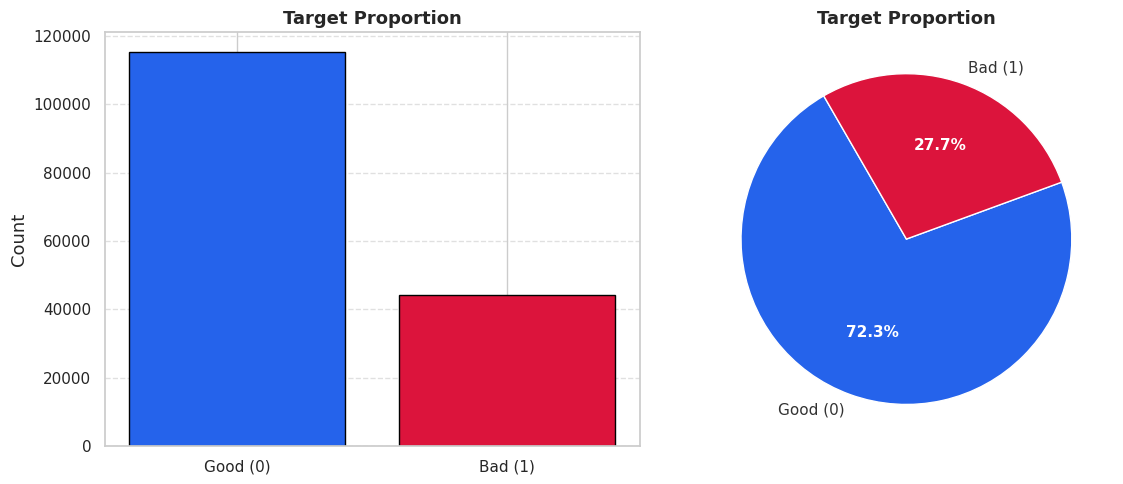

In [12]:
# Target Variable Analysis 
target = 'loanDefault'

print("Target Variable Analysis")
if target in df.columns:
    counts = df[target].value_counts().sort_index()
    props = counts / len(df) * 100

    for value, count in counts.items():
        label = "Good (False)" if value == False else "Bad (True)"
        print(f"{label}: {count:,} ({props[value]:.1f}%)")

    colors = ['#2563EB', '#DC143C']  
    labels = ['Good (0)', 'Bad (1)']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    bars = ax1.bar(labels, counts.values, color=colors, edgecolor='black')
    ax1.set_title('Target Proportion', fontsize=13, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('Count', fontsize=13)
    ax1.grid(axis='y', linestyle='--', alpha=0.6)

    wedges, texts, autotexts = ax2.pie(
        counts,
        labels=labels,
        autopct='%1.1f%%',
        colors=colors,
        startangle=120,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 11, 'color': '#333'}
    )
    plt.setp(autotexts, size=11, weight="bold", color="white")
    ax2.set_title('Target Proportion', fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.show()

else:
    print(f"Column '{target}' not found in DataFrame.")

In [13]:
# Feature Analysis Numeric
if df[target].nunique() == 2:
    correlations = df[numeric_cols].corr()[target].sort_values(ascending=False)
    
    print("Correlation Matrix:")
    print(correlations)

Correlation Matrix:
loanDefault                  1.000000
settleDays                   0.629909
paymentRatio                 0.568759
interestRate                 0.079183
dueDateMonth                 0.019052
disbursementDateMonth        0.015514
FirstPaymentDueDateMonth     0.015231
applicationDateMonth         0.014520
approvalDateMonth            0.014518
loanTerm                     0.009258
loanIncomeRatio              0.006391
loanAmount                  -0.017462
clientAvgCallsPerDay        -0.026534
clientNumberPhoneContacts   -0.026686
clientIncome                -0.035291
clientAge                   -0.048477
loanNumber                  -0.080719
Name: loanDefault, dtype: float64


In [14]:
# Feature Analysis Categorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))
    
print("Cramér's Value:")
for col in categorical_cols:
    cv = cramers_v(df[col], df[target])
    print(f"{col}: {cv:.3f}")

Cramér's Value:
loanId: 0.690
incomeVerified: 0.050
clientGender: 0.026
clientMaritalStatus: 0.025
clientLoanPurpose: 0.080
clientResidentialStatus: 0.023
clientTimeAtEmployer: 0.026
maxAmountTaken: 0.101
maxTenorTaken: 0.104
firstPaymentDefault: 0.625
repaidDateMonth: 0.610


# **Data Preprocessing**

In [15]:
# Create a copy for preprocessing
df_processed = df.copy()

# Handling Duplicate Values
def handle_duplicates(df):
    print("Handling Duplicate Values")

    # Count duplicates before cleaning
    duplicate_before = df.duplicated().sum()
    print(f"Number of duplicate rows before cleaning: {duplicate_before}")

    # Drop duplicate rows
    df_cleaned = df.drop_duplicates()

    # Count duplicates after cleaning
    duplicate_after = df_cleaned.duplicated().sum()
    print(f"Number of duplicate rows after cleaning: {duplicate_after}")
    print(f"Shape before: {df.shape}")
    print(f"Shape after: {df_cleaned.shape}")

    return df_cleaned

df_processed = handle_duplicates(df_processed)

Handling Duplicate Values
Number of duplicate rows before cleaning: 12
Number of duplicate rows after cleaning: 0
Shape before: (159596, 28)
Shape after: (159584, 28)


In [16]:
# List of columns to drop
cols_to_drop = [
    "dueDateMonth", "disbursementDateMonth", "FirstPaymentDueDateMonth",
    "applicationDateMonth", "approvalDateMonth", "loanTerm", "clientAvgCallsPerDay", "clientNumberPhoneContacts", 
    "incomeVerified", "loanId", "loanIncomeRatio", "clientGender", "clientMaritalStatus",
    "clientResidentialStatus", "clientTimeAtEmployer", "clientLoanPurpose"
]

print(f"Shape before dropping columns: {df_processed.shape}")
df_processed.drop(columns=cols_to_drop, inplace=True)
print(f"Shape after dropping columns: {df_processed.shape}")
print(f"Dropped columns: {cols_to_drop}")

df_processed.head()

Shape before dropping columns: (159584, 28)
Shape after dropping columns: (159584, 12)
Dropped columns: ['dueDateMonth', 'disbursementDateMonth', 'FirstPaymentDueDateMonth', 'applicationDateMonth', 'approvalDateMonth', 'loanTerm', 'clientAvgCallsPerDay', 'clientNumberPhoneContacts', 'incomeVerified', 'loanId', 'loanIncomeRatio', 'clientGender', 'clientMaritalStatus', 'clientResidentialStatus', 'clientTimeAtEmployer', 'clientLoanPurpose']


,clientIncome,clientAge,loanNumber,loanAmount,interestRate,maxAmountTaken,maxTenorTaken,settleDays,paymentRatio,firstPaymentDefault,loanDefault,repaidDateMonth
0,66452.66,38,1,42000,6.0,True,True,-9,0.0,False,0,5
1,35000.00,35,1,20000,6.0,False,True,6,0.0,False,0,6
2,162851.11,47,1,134000,6.0,False,True,23,0.0,True,0,6
3,55053.68,33,1,34500,6.0,True,True,-7,0.0,False,1,5
4,32112.55,30,1,20000,6.0,True,True,19,0.0,True,0,6


In [17]:
# Identify categorical columns
categorical_cols = df_processed.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical Columns:", categorical_cols)

Categorical Columns: ['repaidDateMonth']


In [18]:
df_processed['repaidDateMonth'].head()

0    5
1    6
2    6
3    5
4    6
Name: repaidDateMonth, dtype: object

In [19]:
# Ensure the data is numeric
df_processed['repaidDateMonth'] = pd.to_numeric(df_processed['repaidDateMonth'], errors='coerce')

# Handle any missing or invalid values
df_processed['repaidDateMonth'].fillna(df_processed['repaidDateMonth'].mode()[0], inplace=True)

# Apply cyclical encoding
df_processed['repaidMonth_sin'] = np.sin(2 * np.pi * df_processed['repaidDateMonth'] / 12)
df_processed['repaidMonth_cos'] = np.cos(2 * np.pi * df_processed['repaidDateMonth'] / 12)

# Drop the original column to avoid redundancy
df_processed.drop(columns=['repaidDateMonth'], inplace=True)

# Check the results
df_processed[['repaidMonth_sin', 'repaidMonth_cos']].head()

/tmp/ipykernel_122/1287970600.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['repaidDateMonth'].fillna(df_processed['repaidDateMonth'].mode()[0], inplace=True)


,repaidMonth_sin,repaidMonth_cos
0,5.000000e-01,-0.866025
1,1.224647e-16,-1.000000
2,1.224647e-16,-1.000000
3,5.000000e-01,-0.866025
4,1.224647e-16,-1.000000


In [20]:
print("Preview Dataset")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
df_processed.head()

Preview Dataset


,clientIncome,clientAge,loanNumber,loanAmount,interestRate,maxAmountTaken,maxTenorTaken,settleDays,paymentRatio,firstPaymentDefault,loanDefault,repaidMonth_sin,repaidMonth_cos
0,66452.66,38,1,42000,6.0,True,True,-9,0.0,False,0,5.000000e-01,-0.866025
1,35000.00,35,1,20000,6.0,False,True,6,0.0,False,0,1.224647e-16,-1.000000
2,162851.11,47,1,134000,6.0,False,True,23,0.0,True,0,1.224647e-16,-1.000000
3,55053.68,33,1,34500,6.0,True,True,-7,0.0,False,1,5.000000e-01,-0.866025
4,32112.55,30,1,20000,6.0,True,True,19,0.0,True,0,1.224647e-16,-1.000000


In [21]:
# Rename Columns
rename_dict = { 
    "clientIncome": "client_income",
    "clientAge": "client_age",
    "loanNumber": "loan_number",
    "loanAmount": "loan_amount",
    "interestRate": "interest_rate",
    "maxAmountTaken": "max_amount_taken",
    "maxTenorTaken": "max_tenor_taken",
    "settleDays": "settle_days",
    "paymentRatio": "payment_ratio",
    "firstPaymentDefault": "first_payment_default",
    "loanDefault": "loan_default",
    "repaidMonth_sin": "repaid_month_sin",
    "repaidMonth_cos": "repaid_month_cos"
}

# Rename only existing columns
df_processed = df_processed.rename(columns={k: v for k, v in rename_dict.items() if k in df_processed.columns})

print("Columns After Renaming:")
print(df_processed.head())

Columns After Renaming:
   client_income  client_age  loan_number  loan_amount  interest_rate  \
0       66452.66          38            1        42000            6.0   
1       35000.00          35            1        20000            6.0   
2      162851.11          47            1       134000            6.0   
3       55053.68          33            1        34500            6.0   
4       32112.55          30            1        20000            6.0   

   max_amount_taken  max_tenor_taken  settle_days  payment_ratio  \
0              True             True           -9            0.0   
1             False             True            6            0.0   
2             False             True           23            0.0   
3              True             True           -7            0.0   
4              True             True           19            0.0   

   first_payment_default  loan_default  repaid_month_sin  repaid_month_cos  
0                  False             0      5.00000

# **Feature Engineering & Selection**

In [22]:
# Feature Engineering
def feature_engineering(df_processed):
    df_new = df_processed.copy()

    df_new["loan_income_ratio"] = df_new["loan_amount"] / (df_new["client_income"] + 1)
    df_new["income_to_loan_ratio"] = df_new["client_income"] / (df_new["loan_amount"] + 1)
    df_new["log_income"] = np.log1p(df_new["client_income"])
    df_new["log_loan"] = np.log1p(df_new["loan_amount"])
    df_new["log_settle_days"] = np.log1p(np.abs(df_new["settle_days"]))
    df_new["age_squared"] = df_new["client_age"] ** 2
    df_new["high_dti"] = (df_new["loan_income_ratio"] > 0.6).astype(bool)
    df_new["first_payment_issue"] = df_new["first_payment_default"].astype(bool)
    df_new["delayed_settlement"] = (df_new["settle_days"] < 0).astype(bool)
    df_new["low_payment_ratio"] = (df_new["payment_ratio"] < 0.5).astype(bool)
    df_new["repeat_borrower"] = (df_new["loan_number"] > 1).astype(bool)
    df_new["risk_score"] = (
        2 * df_new["high_dti"] +
        2 * (df_new["delayed_settlement"] + 2 * df_new["first_payment_issue"]) +
        df_new["low_payment_ratio"] +
        df_new["repeat_borrower"]
    ).astype(int)

    return df_new

df_engineered = feature_engineering(df_processed)
print("Preview Dataset")
df_engineered.head()

Preview Dataset


,client_income,client_age,loan_number,loan_amount,interest_rate,max_amount_taken,max_tenor_taken,settle_days,payment_ratio,first_payment_default,loan_default,repaid_month_sin,repaid_month_cos,loan_income_ratio,income_to_loan_ratio,log_income,log_loan,log_settle_days,age_squared,high_dti,first_payment_issue,delayed_settlement,low_payment_ratio,repeat_borrower,risk_score
0,66452.66,38,1,42000,6.0,True,True,-9,0.0,False,0,5.000000e-01,-0.866025,0.632019,1.582169,11.104260,10.645449,2.302585,1444,True,False,True,True,False,5
1,35000.00,35,1,20000,6.0,False,True,6,0.0,False,0,1.224647e-16,-1.000000,0.571412,1.749913,10.463132,9.903538,1.945910,1225,False,False,False,True,False,1
2,162851.11,47,1,134000,6.0,False,True,23,0.0,True,0,1.224647e-16,-1.000000,0.822832,1.215298,12.000598,11.805603,3.178054,2209,True,True,False,True,False,7
3,55053.68,33,1,34500,6.0,True,True,-7,0.0,False,1,5.000000e-01,-0.866025,0.626650,1.595713,10.916082,10.448744,2.079442,1089,True,False,True,True,False,5
4,32112.55,30,1,20000,6.0,True,True,19,0.0,True,0,1.224647e-16,-1.000000,0.622790,1.605547,10.377033,9.903538,2.995732,900,True,True,False,True,False,7


In [23]:
# Feature Analysis Numeric After Feature Engineering
def analyze_numeric_correlation(df_engineered, target="loan_default"):

    if target not in df_engineered.columns:
        print(f"Target column '{target}' not found.")
        return None

    if not np.issubdtype(df_engineered[target].dtype, np.number):
        df_engineered[target] = df_engineered[target].astype(int)

    if df_engineered[target].nunique() != 2:
        print("Target not biner, analysis correlation not relevant.")
        return None

    numeric_df = df_engineered.select_dtypes(include=[np.number])
    correlations = numeric_df.corr()[target].drop(target).sort_values(key=abs, ascending=False)

    print("Correlation Matrix:")
    for col, corr in correlations.items():
        print(f"{col:<30} {corr:>10.4f}")
        
    return correlations

correlations = analyze_numeric_correlation(df_engineered)

Correlation Matrix:
settle_days                        0.6299
log_settle_days                    0.6032
payment_ratio                      0.5686
risk_score                         0.3524
repaid_month_cos                  -0.2052
repaid_month_sin                   0.1008
loan_number                       -0.0807
interest_rate                      0.0792
log_income                        -0.0494
client_age                        -0.0485
age_squared                       -0.0433
client_income                     -0.0353
log_loan                          -0.0217
loan_amount                       -0.0174
income_to_loan_ratio              -0.0159
loan_income_ratio                  0.0066


In [24]:
# Feature Analysis Categorical After Feature Engineering
def categorical_association(df_engineered, target_col="loan_default"):
    if target_col not in df_engineered.columns:
        print(f"Target column '{target_col}' not found.")
        return None

    categorical_cols = [
        col for col in df_engineered.columns
        if (df_engineered[col].dtype == bool)
        and col != target_col
    ]

    if not categorical_cols:
        print("No categorical or boolean columns found.")
        return None

    print("Cramér's Values:")

    results = []
    for col in categorical_cols:
        try:
            cv = cramers_v(df_engineered[col], df_engineered[target_col])
            results.append((col, cv))
        except Exception as e:
            print(f"{col:<30} Error: {e}")

    results.sort(key=lambda x: x[1], reverse=True)

    for col, cv in results:
        print(f"{col:<30} Cramér’s V: {cv:>6.3f}")

    return pd.DataFrame(results, columns=["Feature", "Cramers_V"])

assoc_results = categorical_association(df_engineered, target_col="loan_default")

Cramér's Values:
first_payment_default          Cramér’s V:  0.625
first_payment_issue            Cramér’s V:  0.625
low_payment_ratio              Cramér’s V:  0.547
delayed_settlement             Cramér’s V:  0.388
max_tenor_taken                Cramér’s V:  0.104
max_amount_taken               Cramér’s V:  0.101
high_dti                       Cramér’s V:  0.037
repeat_borrower                Cramér’s V:  0.006


In [25]:
# List of columns to drop
cols_drop = [
    "high_dti", "repeat_borrower", "age_squared",
    "client_income", "log_loan", "loan_amount", 
    "income_to_loan_ratio", "loan_income_ratio"
]

df_fix = df_engineered.drop(columns=cols_drop)

print(f"Dropped columns: {cols_drop}")
print(f"Shape before dropping columns: {df_engineered.shape}")
print(f"Shape after dropping columns: {df_fix.shape}")

Dropped columns: ['high_dti', 'repeat_borrower', 'age_squared', 'client_income', 'log_loan', 'loan_amount', 'income_to_loan_ratio', 'loan_income_ratio']
Shape before dropping columns: (159584, 25)
Shape after dropping columns: (159584, 17)


In [26]:
print("Preview Dataset (df_fix)")
df_fix.head()

Preview Dataset (df_fix)


,client_age,loan_number,interest_rate,max_amount_taken,max_tenor_taken,settle_days,payment_ratio,first_payment_default,loan_default,repaid_month_sin,repaid_month_cos,log_income,log_settle_days,first_payment_issue,delayed_settlement,low_payment_ratio,risk_score
0,38,1,6.0,True,True,-9,0.0,False,0,5.000000e-01,-0.866025,11.104260,2.302585,False,True,True,5
1,35,1,6.0,False,True,6,0.0,False,0,1.224647e-16,-1.000000,10.463132,1.945910,False,False,True,1
2,47,1,6.0,False,True,23,0.0,True,0,1.224647e-16,-1.000000,12.000598,3.178054,True,False,True,7
3,33,1,6.0,True,True,-7,0.0,False,1,5.000000e-01,-0.866025,10.916082,2.079442,False,True,True,5
4,30,1,6.0,True,True,19,0.0,True,0,1.224647e-16,-1.000000,10.377033,2.995732,True,False,True,7


In [27]:
# Check & Remove Duplicate Columns
print("Check & Remove Duplicate Columns")

duplicate_cols = df_fix.columns[df_fix.columns.duplicated()].tolist()
if duplicate_cols:
    print(f"Duplicate columns found: {duplicate_cols}")
    df_fix = df_fix.loc[:, ~df_fix.columns.duplicated()]
    print("Duplicate columns successfully removed.")
else:
    print("No duplicate columns found.")

print(f"Total columns after cleanup: {len(df_fix.columns)}")

Check & Remove Duplicate Columns
No duplicate columns found.
Total columns after cleanup: 17


In [28]:
df_fix.head()

,client_age,loan_number,interest_rate,max_amount_taken,max_tenor_taken,settle_days,payment_ratio,first_payment_default,loan_default,repaid_month_sin,repaid_month_cos,log_income,log_settle_days,first_payment_issue,delayed_settlement,low_payment_ratio,risk_score
0,38,1,6.0,True,True,-9,0.0,False,0,5.000000e-01,-0.866025,11.104260,2.302585,False,True,True,5
1,35,1,6.0,False,True,6,0.0,False,0,1.224647e-16,-1.000000,10.463132,1.945910,False,False,True,1
2,47,1,6.0,False,True,23,0.0,True,0,1.224647e-16,-1.000000,12.000598,3.178054,True,False,True,7
3,33,1,6.0,True,True,-7,0.0,False,1,5.000000e-01,-0.866025,10.916082,2.079442,False,True,True,5
4,30,1,6.0,True,True,19,0.0,True,0,1.224647e-16,-1.000000,10.377033,2.995732,True,False,True,7


# **Data Splitting & Feature Scaling**

In [29]:
# Split Features and Target
print("Split Features and Target")

# Separate input features (X) and target variable (y)
X = df_fix.drop('loan_default', axis=1)
y = df_fix['loan_default']

# Check target distribution
print("Target Distribution (loan_default):")
print(y.value_counts(normalize=True))

# Split into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Display dataset shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test:  {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test:  {y_test.shape}")

print("Training Data Preview")
display(X_train.head())

Split Features and Target
Target Distribution (loan_default):
loan_default
0    0.722635
1    0.277365
Name: proportion, dtype: float64
Shape of X_train: (127667, 16)
Shape of X_test:  (31917, 16)
Shape of y_train: (127667,)
Shape of y_test:  (31917,)
Training Data Preview


,client_age,loan_number,interest_rate,max_amount_taken,max_tenor_taken,settle_days,payment_ratio,first_payment_default,repaid_month_sin,repaid_month_cos,log_income,log_settle_days,first_payment_issue,delayed_settlement,low_payment_ratio,risk_score
50813,45,5,7.5,True,True,-1,0.0,False,1.000000,6.123234e-17,10.126671,0.693147,False,True,True,6
117742,35,4,10.0,False,False,-19,0.0,False,-0.866025,-5.000000e-01,9.615872,2.995732,False,True,True,6
37604,24,3,12.5,True,True,49,0.0,True,0.500000,-8.660254e-01,11.156265,3.912023,True,False,True,6
118749,38,3,10.0,True,True,179,1.0,True,0.500000,-8.660254e-01,10.868587,5.192957,True,False,False,7
133479,30,2,7.5,False,False,0,0.0,False,-0.500000,-8.660254e-01,10.308986,0.000000,False,False,True,4


In [30]:
# Feature Scaling 
numerical = [
    'client_age', 'loan_number', 'interest_rate', 'settle_days',
    'payment_ratio', 'repaid_month_sin', 'repaid_month_cos', 'log_income',
    'log_settle_days', 'risk_score'
]

# Initialize the scaler
scaler = StandardScaler()

# Ensure only existing numerical columns are used
available_numerical = [col for col in numerical if col in X_train.columns]

# Fit-transform on the training set, transform on the test set
X_train.loc[:, available_numerical] = scaler.fit_transform(X_train[available_numerical])
X_test.loc[:, available_numerical] = scaler.transform(X_test[available_numerical])

print(f"Number of scaled numerical features: {len(available_numerical)}")
print(f"Scaled features: {available_numerical}")
print("Preview of X_train after scaling:")
display(X_train.head())

Number of scaled numerical features: 10
Scaled features: ['client_age', 'loan_number', 'interest_rate', 'settle_days', 'payment_ratio', 'repaid_month_sin', 'repaid_month_cos', 'log_income', 'log_settle_days', 'risk_score']
Preview of X_train after scaling:


/tmp/ipykernel_122/36263803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.57517844  0.18280088 -1.34881443 ...  0.46127639  0.32203864
 -0.23491239]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, available_numerical] = scaler.fit_transform(X_train[available_numerical])
/tmp/ipykernel_122/36263803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.58322958  0.17943579 -0.224358   ... -0.62815178 -0.62815178
 -0.62815178]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, available_numerical] = scaler.fit_transform(X_train[available_numerical])
/tmp/ipykernel_122/36263803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.3973926  -0.61056009 

,client_age,loan_number,interest_rate,max_amount_taken,max_tenor_taken,settle_days,payment_ratio,first_payment_default,repaid_month_sin,repaid_month_cos,log_income,log_settle_days,first_payment_issue,delayed_settlement,low_payment_ratio,risk_score
50813,1.575178,0.583230,-1.307836,True,True,-0.397393,-0.351580,False,1.300659,0.535068,-1.034303,-0.768801,False,True,True,0.790471
117742,0.182801,0.179436,-0.748283,False,False,-0.610560,-0.351580,False,-1.292683,-0.285022,-1.623203,0.560953,False,True,True,0.790471
37604,-1.348814,-0.224358,-0.188730,True,True,0.194739,-0.351580,True,0.605775,-0.885369,0.152716,1.090114,True,False,True,0.790471
118749,0.600514,-0.224358,-0.748283,True,True,1.734282,3.254785,True,0.605775,-0.885369,-0.178947,1.829859,True,False,False,1.341786
133479,-0.513388,-0.628152,-1.307836,False,False,-0.385550,-0.351580,False,-0.783992,-0.885369,-0.824112,-1.169096,False,False,True,-0.312158


# **Handle Imbalance**

In [31]:
pip install --upgrade scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Handle Imbalanced Dataset with SMOTE Oversampling
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=42)

# Apply SMOTE to training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check distribution
class_counts = pd.Series(y_train_resampled).value_counts()
print("Class distribution after SMOTE:")
print(class_counts)

ratio = class_counts.max() / class_counts.min()
print(f"Balanced ratio: {ratio:.2f}:1")
print(f"\nX_train_resampled shape: {X_train_resampled.shape}")
print(f"y_train_resampled shape: {y_train_resampled.shape}")

Class distribution after SMOTE:
loan_default
0    92257
1    92257
Name: count, dtype: int64
Balanced ratio: 1.00:1

X_train_resampled shape: (184514, 16)
y_train_resampled shape: (184514,)


# **Model Training**

In [33]:
# Logistic Regression
def evaluate_logreg(X_train_resampled, y_train_resampled, X_test, y_test):
    print("Logistic Regression")
    
    # Initialize Logistic Regression model
    log_reg = LogisticRegression(
        solver="liblinear",
        random_state=42
    )
    
    # Perform cross-validation using StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=cv, scoring="f1")
    
    print("Cross-Validation (F1 per fold):", cv_scores)
    print("Average F1 from Cross-Validation:", np.mean(cv_scores))
    
    # Fit model on training data
    log_reg.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = log_reg.predict(X_test)
    
    print("\nEvaluation on Test Set")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-Score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return log_reg

logreg_model = evaluate_logreg(X_train_resampled, y_train_resampled, X_test, y_test)

Logistic Regression
Cross-Validation (F1 per fold): [0.80678045 0.80509362 0.81065502 0.80207114 0.80921321]
Average F1 from Cross-Validation: 0.8067626881894338

Evaluation on Test Set
Accuracy : 0.8495472632139612
Precision: 0.7216325637378269
Recall   : 0.7449452163108551
F1-Score : 0.7331036016007114
ROC-AUC  : 0.8173217236601101

Confusion Matrix:
 [[20520  2544]
 [ 2258  6595]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90     23064
           1       0.72      0.74      0.73      8853

    accuracy                           0.85     31917
   macro avg       0.81      0.82      0.81     31917
weighted avg       0.85      0.85      0.85     31917



In [34]:
# XGBoost
def evaluate_xgb(X_train_resampled, y_train_resampled, X_test, y_test):
    print("XGBoost")
    
    # Initialize XGBoost model
    xgb_clf = xgb.XGBClassifier(
        n_estimators=100,         
        learning_rate=0.05,        
        max_depth=5,              
        subsample=0.6,            
        colsample_bytree=0.8,     
        random_state=42,
        eval_metric="logloss",    
        n_jobs=-1                
    )
    
    # Perform cross-validation using StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        xgb_clf, X_train_resampled, y_train_resampled, cv=cv, scoring="f1", n_jobs=-1
    )
    print("Cross-validation (F1 per fold):", cv_scores)
    print("Average F1 from cross-validation:", np.mean(cv_scores))
    
    # Fit model on training data
    xgb_clf.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = xgb_clf.predict(X_test)
    
    print("\nEvaluation on Test Set")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-Score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    return xgb_clf

xgb_model = evaluate_xgb(X_train_resampled, y_train_resampled, X_test, y_test)

XGBoost
Cross-validation (F1 per fold): [0.85464456 0.85875039 0.86158623 0.85392621 0.86040918]
Average F1 from cross-validation: 0.8578633129940698

Evaluation on Test Set
Accuracy : 0.856252154024501
Precision: 0.7488041068720103
Recall   : 0.7249519936744606
F1-Score : 0.7366850321395776
ROC-AUC  : 0.8158015258001161

Confusion Matrix:
 [[20911  2153]
 [ 2435  6418]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90     23064
           1       0.75      0.72      0.74      8853

    accuracy                           0.86     31917
   macro avg       0.82      0.82      0.82     31917
weighted avg       0.85      0.86      0.86     31917



In [35]:
# Random Forest
def evaluate_rf(X_train_resampled, y_train_resampled, X_test, y_test):
    print("Random Forest")
    
    # Initialize Random Forest model
    rf_clf = RandomForestClassifier(
        n_estimators=300,      
        max_depth=None,        
        random_state=42,
        n_jobs=-1              
    )
    
    # Perform cross-validation using StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        rf_clf, X_train_resampled, y_train_resampled, cv=cv, scoring="f1", n_jobs=-1
    )
    print("Cross-validation (F1 per fold):", cv_scores)
    print("Average F1 from cross-validation:", np.mean(cv_scores))
    
    # Fit model on training data
    rf_clf.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = rf_clf.predict(X_test)
    
    print("\nEvaluation on Test Set")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-Score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return rf_clf
    
rf_model = evaluate_rf(X_train_resampled, y_train_resampled, X_test, y_test)

Random Forest


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross-validation (F1 per fold): [0.89575397 0.89920284 0.89732849 0.89607133 0.90097055]
Average F1 from cross-validation: 0.8978654360452492

Evaluation on Test Set
Accuracy : 0.8562834852899709
Precision: 0.7818446088794926
Recall   : 0.668361007568056
F1-Score : 0.7206625662261738
ROC-AUC  : 0.7983887937597477

Confusion Matrix:
 [[21413  1651]
 [ 2936  5917]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90     23064
           1       0.78      0.67      0.72      8853

    accuracy                           0.86     31917
   macro avg       0.83      0.80      0.81     31917
weighted avg       0.85      0.86      0.85     31917



ROC Curve Comparison


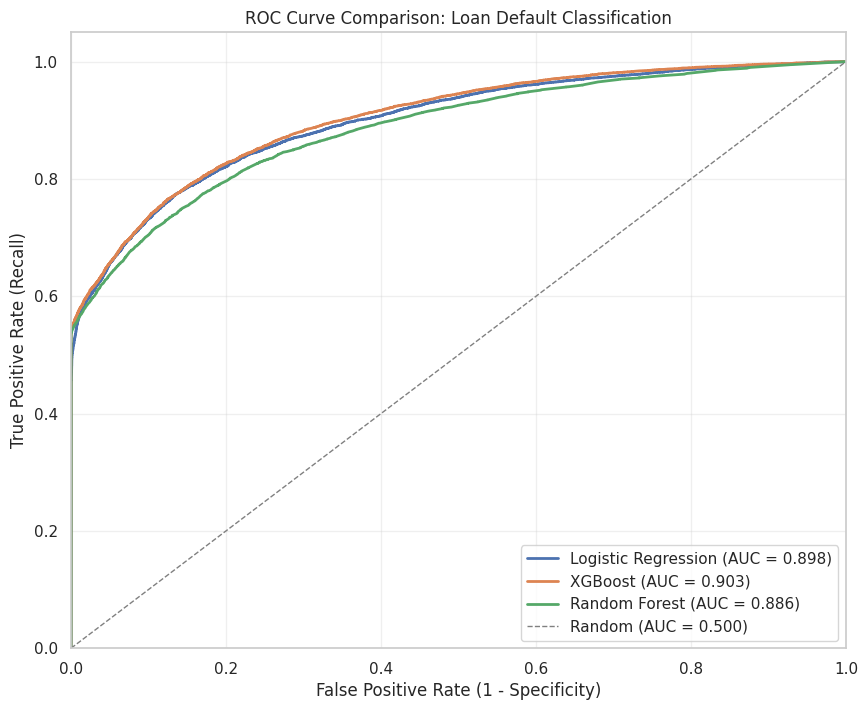


AUC Summary:
Logistic Regression : 0.898
XGBoost             : 0.903
Random Forest       : 0.886


In [36]:
# ROC Curve Comparison
print("ROC Curve Comparison")

# Use pre-trained models
models = {
    "Logistic Regression": logreg_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model
}

# Get predicted probabilities for the positive class
y_probs = {}
for name, model in models.items():
    try:
        y_probs[name] = model.predict_proba(X_test)[:, 1]
    except Exception as e:
        print(f"Could not get probabilities for {name}: {e}")

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1, label='Random (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve Comparison: Loan Default Classification")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print("\nAUC Summary:")
for name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"{name:<20}: {roc_auc:.3f}")

# **Hyperparameter Tunning**

In [37]:
# Hyperparameter Tunning Model Logistic Regression
# Parameter grid
param_dist = {
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

# Model & CV setup
log_reg = LogisticRegression(random_state=42, max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
rand_search = RandomizedSearchCV(
    log_reg,
    param_distributions=param_dist,
    n_iter=20,  
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Searching best parameters...")
rand_search.fit(X_train_resampled, y_train_resampled)

# Best results
print("\nBest Logistic Regression Model")
print("Best Parameters:", rand_search.best_params_)
print(f"Best F1 (CV): {rand_search.best_score_:.4f}")

# Evaluate on test data
best_logreg = rand_search.best_estimator_
y_pred = best_logreg.predict(X_test)

print("\nTest Set Evaluation")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Searching best parameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Logistic Regression Model
Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 0.01}
Best F1 (CV): 0.8078

Test Set Evaluation
Accuracy : 0.8481
Precision: 0.7166
Recall   : 0.7486
F1-Score : 0.7322
ROC-AUC  : 0.8175

Confusion Matrix:
 [[20443  2621]
 [ 2226  6627]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     23064
           1       0.72      0.75      0.73      8853

    accuracy                           0.85     31917
   macro avg       0.81      0.82      0.81     31917
weighted avg       0.85      0.85      0.85     31917



In [38]:
# Hyperparameter Tunning Model XGBoost
def tune_xgb(X_train_resampled, y_train_resampled):
    # Base model
    xgb_clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
    )

    # Parameter grid
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 6, 8, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5],
        'min_child_weight': [1, 3, 5, 7, 10]
    }

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Randomized Search
    random_search = RandomizedSearchCV(
        xgb_clf,
        param_distributions=param_dist,
        n_iter=20,
        scoring='f1',
        cv=cv,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    print("Searching best parameters...")
    random_search.fit(X_train_resampled, y_train_resampled)

    print("\nBest XGBoost Model Evaluation")
    print("Best Parameters:", random_search.best_params_)
    print(f"Best F1 (CV): {random_search.best_score_:.4f}")

    return random_search.best_estimator_

def evaluate_xgb(X_train_resampled, y_train_resampled, X_test, y_test):
    best_xgb = tune_xgb(X_train_resampled, y_train_resampled)

    # Cross-validation 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_xgb, X_train_resampled, y_train_resampled, cv=cv, scoring="f1", n_jobs=-1)

    # Train the best model
    best_xgb.fit(X_train_resampled, y_train_resampled)

    # Test model
    y_pred = best_xgb.predict(X_test)
    y_proba = best_xgb.predict_proba(X_test)[:, 1]  

    # Evaluate performance
    print("\nTest Set Evaluation")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score : {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_test, y_proba):.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

evaluate_xgb(X_train_resampled, y_train_resampled, X_test, y_test)

Searching best parameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best XGBoost Model Evaluation
Best Parameters: {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best F1 (CV): 0.8990

Test Set Evaluation
Accuracy : 0.8691
Precision: 0.8493
Recall   : 0.6422
F1-Score : 0.7313
ROC-AUC  : 0.9010

Confusion Matrix:
 [[22055  1009]
 [ 3168  5685]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     23064
           1       0.85      0.64      0.73      8853

    accuracy                           0.87     31917
   macro avg       0.86      0.80      0.82     31917
weighted avg       0.87      0.87      0.86     31917



In [45]:
# Hyperparameter Tunning Model Random Forest 
def tune_rf(X_train_resampled, y_train_resampled):
    # Base model
    rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

    # Parameter grid
    param_dist = {
        'n_estimators': [100, 200, 300, 400],
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'class_weight': [None, 'balanced']
    }

    # Cross-validation for tuning
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Randomized Search
    random_search = RandomizedSearchCV(
        rf_clf,
        param_distributions=param_dist,
        n_iter=20,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    print("Searching best parameters...")
    random_search.fit(X_train_resampled, y_train_resampled)

    print("\nBest Random Forest Model Evaluation")
    print("Best Parameters:", random_search.best_params_)
    print(f"Best F1 (CV): {random_search.best_score_:.4f}")
    
    return random_search.best_estimator_

def evaluate_rf(X_train_resampled, y_train_resampled, X_test, y_test):
    best_rf = tune_rf(X_train_resampled, y_train_resampled)

    # Cross-validation 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_rf, X_train_resampled, y_train_resampled, cv=cv, scoring='f1', n_jobs=-1)

    # Train the best model
    best_rf.fit(X_train_resampled, y_train_resampled)

    # Test model
    y_pred = best_rf.predict(X_test)
    y_prob = best_rf.predict_proba(X_test)[:, 1]

    # Evaluate performance
    print("\nTest Set Evaluation")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score : {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

evaluate_rf(X_train_resampled, y_train_resampled, X_test, y_test)

Searching best parameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Random Forest Model Evaluation
Best Parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'class_weight': None}
Best F1 (CV): 0.8862

Test Set Evaluation
Accuracy : 0.8597
Precision: 0.7707
Recall   : 0.7037
F1-Score : 0.7357
ROC-AUC  : 0.8998

Confusion Matrix:
 [[21210  1854]
 [ 2623  6230]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     23064
           1       0.77      0.70      0.74      8853

    accuracy                           0.86     31917
   macro avg       0.83      0.81      0.82     31917
weighted avg       0.86      0.86      0.86     31917



In [40]:
# Training Model Logistic Regression After Hyperparameter Tunning
def evaluate_logreg(X_train_resampled, y_train_resampled, X_test, y_test):
    print("Logistic Regression")
    
    # Initialize Logistic Regression model
    log_reg = LogisticRegression(
        solver='liblinear',
        penalty='l2',
        C=0.01,
        class_weight=None,
        random_state=42
    )
    
    # Perform cross-validation using StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(log_reg, X_train_resampled, y_train_resampled, cv=cv, scoring="f1")
    
    print("Cross-Validation (F1 per fold):", cv_scores)
    print("Average F1 from Cross-Validation:", np.mean(cv_scores))
    
    # Fit model on training data
    log_reg.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = log_reg.predict(X_test)
    
    print("\nEvaluation on Test Set")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-Score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return log_reg

logreg_model1 = evaluate_logreg(X_train_resampled, y_train_resampled, X_test, y_test)

Logistic Regression
Cross-Validation (F1 per fold): [0.80793665 0.80652262 0.81109628 0.80361095 0.81007516]
Average F1 from Cross-Validation: 0.8078483306839324

Evaluation on Test Set
Accuracy : 0.8481373562678196
Precision: 0.7165873702422145
Recall   : 0.748559810233819
F1-Score : 0.7322247389646981
ROC-AUC  : 0.8174597524981096

Confusion Matrix:
 [[20443  2621]
 [ 2226  6627]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89     23064
           1       0.72      0.75      0.73      8853

    accuracy                           0.85     31917
   macro avg       0.81      0.82      0.81     31917
weighted avg       0.85      0.85      0.85     31917



In [41]:
# Training Model XGBoost After Hyperparameter Tunning
def evaluate_xgb(X_train_resampled, y_train_resampled, X_test, y_test):
    print("XGBoost")
    
    # Initialize XGBoost model
    xgb_clf = xgb.XGBClassifier(
        n_estimators=400,
        min_child_weight=5,
        learning_rate=0.05,        
        max_depth=10,              
        subsample=0.6, 
        gamma=0.3,
        colsample_bytree=0.8,     
        random_state=42,
        eval_metric="logloss",    
        n_jobs=-1                
    )
    
    # Perform cross-validation using StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        xgb_clf, X_train_resampled, y_train_resampled, cv=cv, scoring="f1", n_jobs=-1
    )
    print("Cross-validation (F1 per fold):", cv_scores)
    print("Average F1 from cross-validation:", np.mean(cv_scores))
    
    # Fit model on training data
    xgb_clf.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = xgb_clf.predict(X_test)
    
    print("\nEvaluation on Test Set")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-Score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return xgb_clf

xgb_model1 = evaluate_xgb(X_train_resampled, y_train_resampled, X_test, y_test)

XGBoost


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross-validation (F1 per fold): [0.89608236 0.90096028 0.90139721 0.89469626 0.90169124]
Average F1 from cross-validation: 0.8989654681769015

Evaluation on Test Set
Accuracy : 0.8691293041325939
Precision: 0.8492680011951
Recall   : 0.6421552016265673
F1-Score : 0.7313308033704251
ROC-AUC  : 0.7992036847536236

Confusion Matrix:
 [[22055  1009]
 [ 3168  5685]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     23064
           1       0.85      0.64      0.73      8853

    accuracy                           0.87     31917
   macro avg       0.86      0.80      0.82     31917
weighted avg       0.87      0.87      0.86     31917



In [42]:
# Training Model Random Forest After Hyperparameter Tunning
def evaluate_rf(X_train_resampled, y_train_resampled, X_test, y_test):
    print("Random Forest")
    
    # Initialize Random Forest model
    rf_clf = RandomForestClassifier(
        n_estimators=400,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='log2',
        max_depth=20, 
        class_weight=None,
        random_state=42,
        n_jobs=-1              
    )
    
    # Perform cross-validation using StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        rf_clf, X_train_resampled, y_train_resampled, cv=cv, scoring="f1", n_jobs=-1
    )
    print("Cross-validation (F1 per fold):", cv_scores)
    print("Average F1 from cross-validation:", np.mean(cv_scores))
    
    # Fit model on training data
    rf_clf.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions on the test set
    y_pred = rf_clf.predict(X_test)
    
    print("\nEvaluation on Test Set")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1-Score :", f1_score(y_test, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_test, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return rf_clf
    
rf_model1 = evaluate_rf(X_train_resampled, y_train_resampled, X_test, y_test)

Random Forest


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Cross-validation (F1 per fold): [0.88426004 0.88590641 0.88772175 0.88331748 0.88981277]
Average F1 from cross-validation: 0.886203690318467

Evaluation on Test Set
Accuracy : 0.8597299244916502
Precision: 0.7706580900544285
Recall   : 0.7037162543770473
F1-Score : 0.7356674735785558
ROC-AUC  : 0.8116656193841533

Confusion Matrix:
 [[21210  1854]
 [ 2623  6230]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90     23064
           1       0.77      0.70      0.74      8853

    accuracy                           0.86     31917
   macro avg       0.83      0.81      0.82     31917
weighted avg       0.86      0.86      0.86     31917



In [43]:
# Comparison Output Model
def compare_models(models, X_test, y_test):
    print("Model Comparison")
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"\n{name}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f} | "
              f"Precision: {precision_score(y_test, y_pred):.4f} | "
              f"Recall: {recall_score(y_test, y_pred):.4f} | "
              f"F1: {f1_score(y_test, y_pred):.4f} | "
              f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}")
        # print("\nClassification Report:", classification_report(y_test, y_pred))

models = {
    "Logistic Regression (Before Tuning)": logreg_model,
    "Logistic Regression (After Tuning)": logreg_model1,
    "XGBoost (Before Tuning)": xgb_model,
    "XGBoost (After Tuning)": xgb_model1,
    "Random Forest (Before Tuning)": rf_model,
    "Random Forest (After Tuning)": rf_model1
}

compare_models(models, X_test, y_test)

Model Comparison

Logistic Regression (Before Tuning)
Accuracy: 0.8495 | Precision: 0.7216 | Recall: 0.7449 | F1: 0.7331 | ROC-AUC: 0.8984

Logistic Regression (After Tuning)
Accuracy: 0.8481 | Precision: 0.7166 | Recall: 0.7486 | F1: 0.7322 | ROC-AUC: 0.8981

XGBoost (Before Tuning)
Accuracy: 0.8563 | Precision: 0.7488 | Recall: 0.7250 | F1: 0.7367 | ROC-AUC: 0.9032

XGBoost (After Tuning)
Accuracy: 0.8691 | Precision: 0.8493 | Recall: 0.6422 | F1: 0.7313 | ROC-AUC: 0.9010

Random Forest (Before Tuning)
Accuracy: 0.8563 | Precision: 0.7818 | Recall: 0.6684 | F1: 0.7207 | ROC-AUC: 0.8857

Random Forest (After Tuning)
Accuracy: 0.8597 | Precision: 0.7707 | Recall: 0.7037 | F1: 0.7357 | ROC-AUC: 0.8998


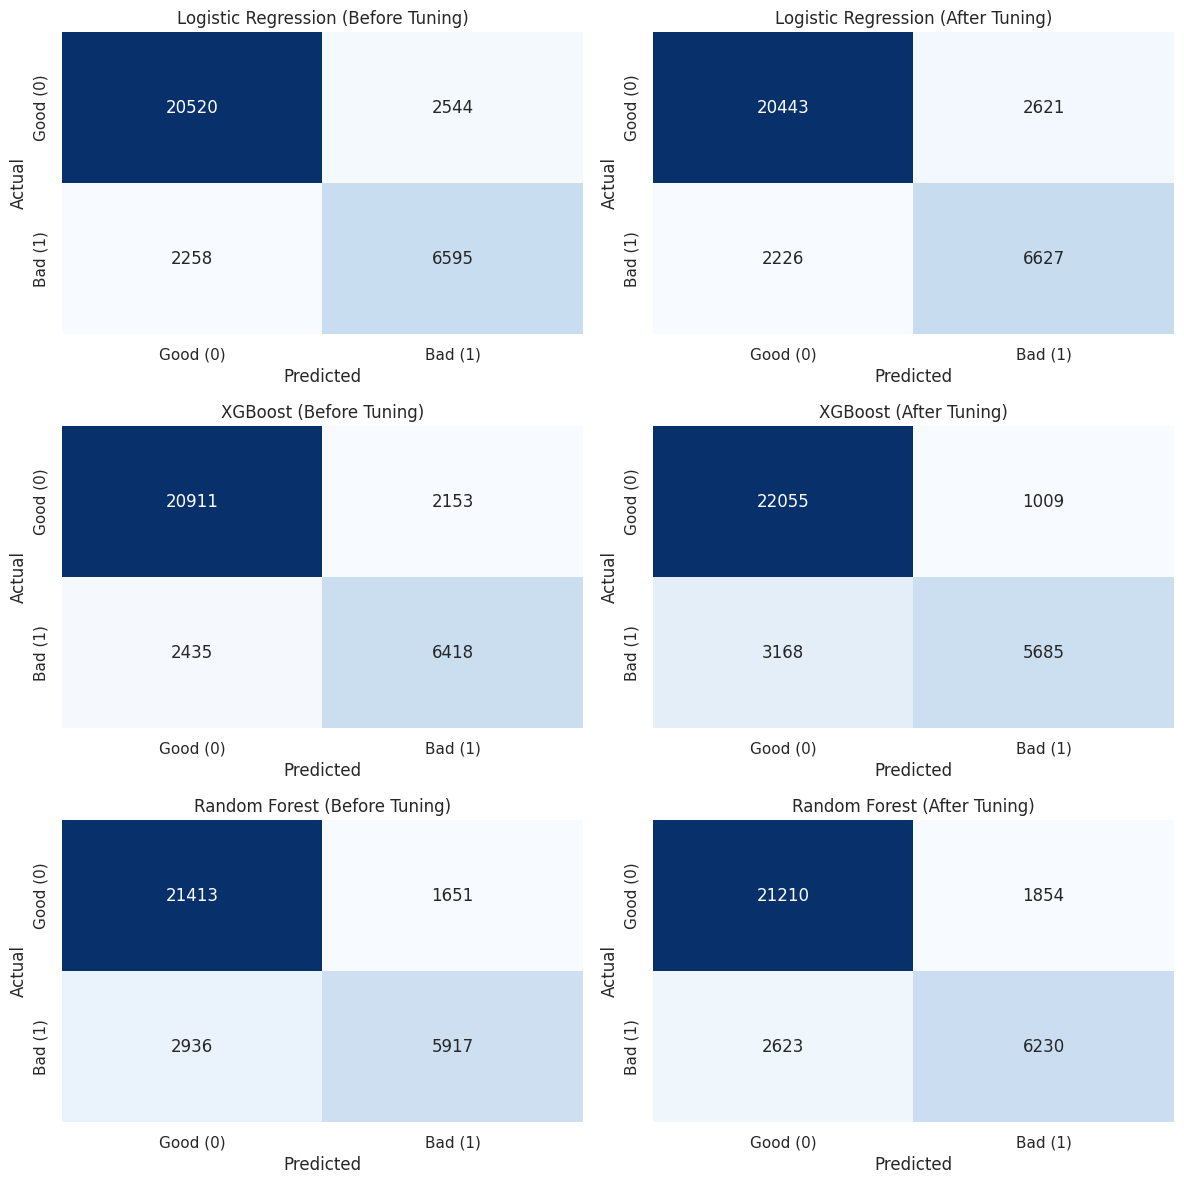

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_side_by_side_heatmaps(models, X_test, y_test):
    """
    Plot confusion matrix heatmaps side-by-side for "Before Tuning" vs "After Tuning".

    Args:
        models (dict): Dictionary of model names and trained models.
        X_test: Test feature data.
        y_test: Test target labels.
    """
    # Urutkan model agar "Before" dan "After" bersebelahan
    model_names = list(models.keys())
    before_models = [models[name] for name in model_names if "Before" in name]
    after_models = [models[name] for name in model_names if "After" in name]

    # Buat figure dengan 3 baris dan 2 kolom
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

    # Judul untuk setiap baris
    row_titles = ["Logistic Regression", "XGBoost", "Random Forest"]

    for i, row_title in enumerate(row_titles):
        # Plot "Before Tuning"
        before_name = f"{row_title} (Before Tuning)"
        before_model = models[before_name]
        y_pred_before = before_model.predict(X_test)
        cm_before = confusion_matrix(y_test, y_pred_before)

        sns.heatmap(
            cm_before,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            ax=axes[i, 0],
            xticklabels=["Good (0)", "Bad (1)"],
            yticklabels=["Good (0)", "Bad (1)"]
        )
        axes[i, 0].set_xlabel("Predicted")
        axes[i, 0].set_ylabel("Actual")
        axes[i, 0].set_title(f"{row_title} (Before Tuning)")

        # Plot "After Tuning"
        after_name = f"{row_title} (After Tuning)"
        after_model = models[after_name]
        y_pred_after = after_model.predict(X_test)
        cm_after = confusion_matrix(y_test, y_pred_after)

        sns.heatmap(
            cm_after,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            ax=axes[i, 1],
            xticklabels=["Good (0)", "Bad (1)"],
            yticklabels=["Good (0)", "Bad (1)"]
        )
        axes[i, 1].set_xlabel("Predicted")
        axes[i, 1].set_ylabel("Actual")
        axes[i, 1].set_title(f"{row_title} (After Tuning)")

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk plot
plot_side_by_side_heatmaps(models, X_test, y_test)

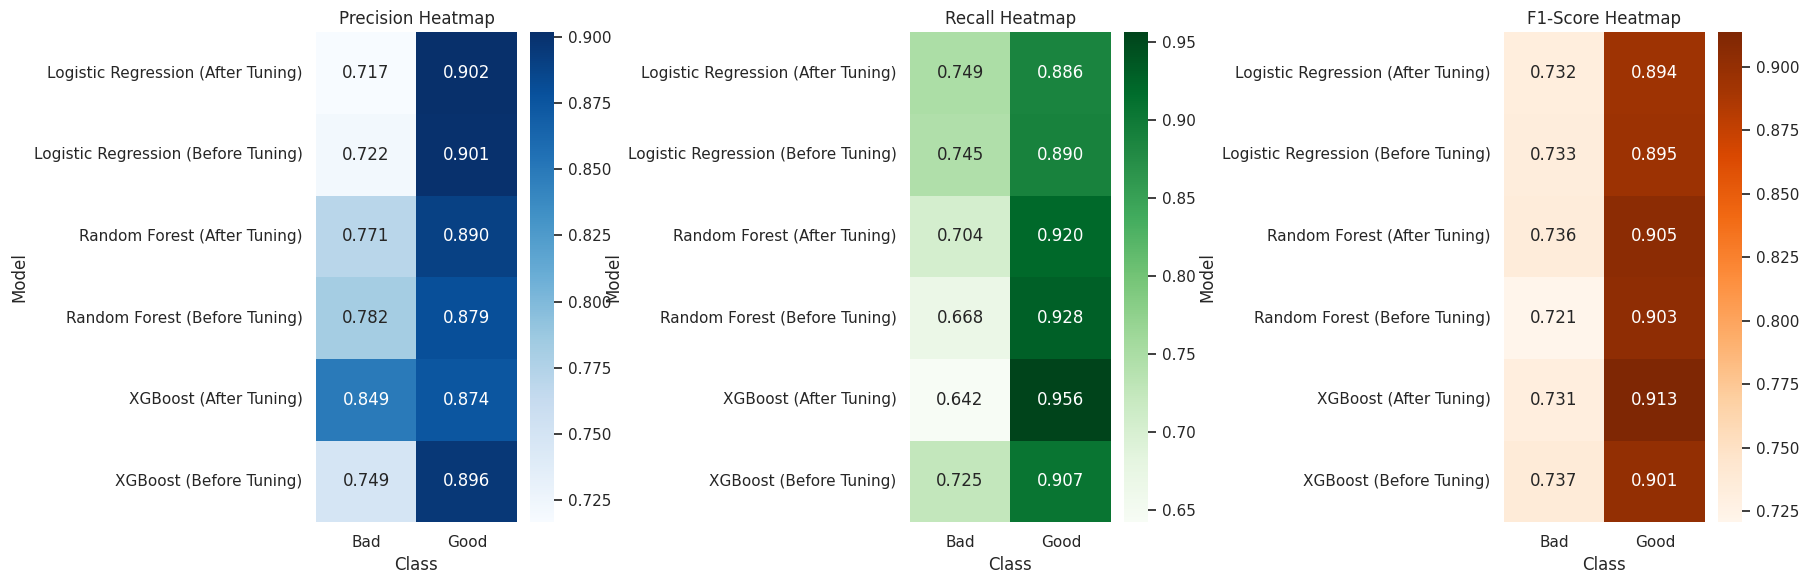

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_classification_report_heatmap(models, X_test, y_test):
    """
    Plot classification report as a heatmap for all models.

    Args:
        models (dict): Dictionary of model names and trained models.
        X_test: Test feature data.
        y_test: Test target labels.
    """
    # Inisialisasi list untuk menyimpan metrik
    metrics_list = []

    for name, model in models.items():
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Simpan metrik untuk kelas 0 dan 1
        for class_label in ["0", "1"]:
            metrics_list.append({
                "Model": name,
                "Class": "Good" if class_label == "0" else "Bad",
                "Precision": report[class_label]["precision"],
                "Recall": report[class_label]["recall"],
                "F1-Score": report[class_label]["f1-score"],
                "Support": report[class_label]["support"]
            })

    # Buat DataFrame dari metrik
    metrics_df = pd.DataFrame(metrics_list)

    # Plot heatmap untuk precision, recall, dan f1-score
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Heatmap Precision
    sns.heatmap(
        metrics_df.pivot(index="Model", columns="Class", values="Precision"),
        annot=True,
        fmt=".3f",
        cmap="Blues",
        ax=axes[0]
    )
    axes[0].set_title("Precision Heatmap")

    # Heatmap Recall
    sns.heatmap(
        metrics_df.pivot(index="Model", columns="Class", values="Recall"),
        annot=True,
        fmt=".3f",
        cmap="Greens",
        ax=axes[1]
    )
    axes[1].set_title("Recall Heatmap")

    # Heatmap F1-Score
    sns.heatmap(
        metrics_df.pivot(index="Model", columns="Class", values="F1-Score"),
        annot=True,
        fmt=".3f",
        cmap="Oranges",
        ax=axes[2]
    )
    axes[2].set_title("F1-Score Heatmap")

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_classification_report_heatmap(models, X_test, y_test)

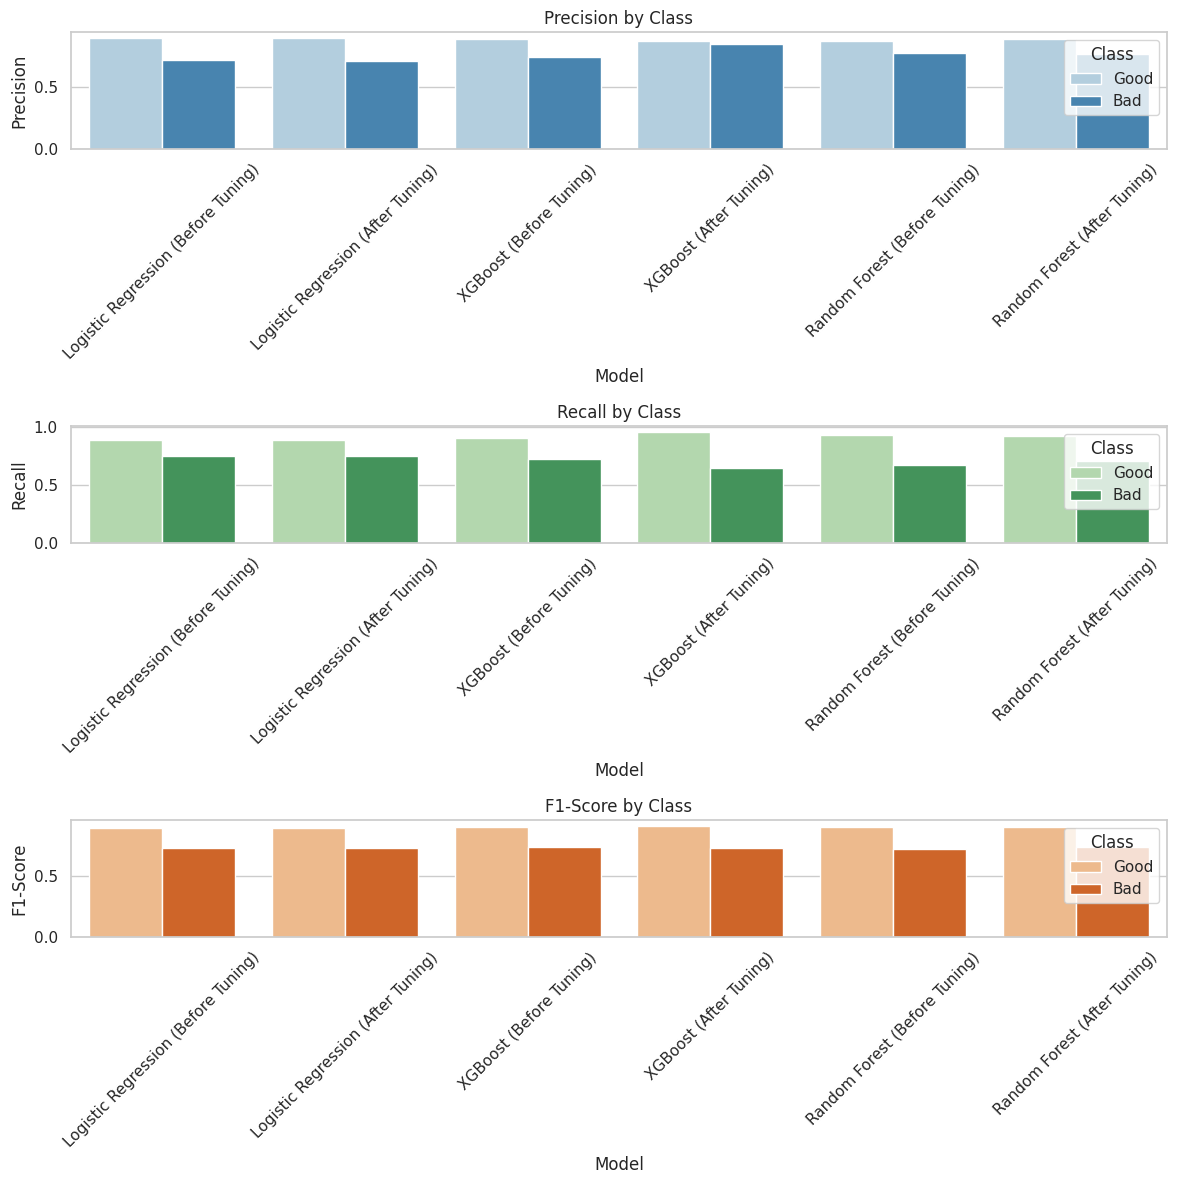

In [49]:
def plot_classification_report_bars(models, X_test, y_test):
    """
    Plot classification report as bar plots for all models.

    Args:
        models (dict): Dictionary of model names and trained models.
        X_test: Test feature data.
        y_test: Test target labels.
    """
    # Inisialisasi list untuk menyimpan metrik
    metrics_list = []

    for name, model in models.items():
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Simpan metrik untuk kelas 0 dan 1
        for class_label in ["0", "1"]:
            metrics_list.append({
                "Model": name,
                "Class": "Good" if class_label == "0" else "Bad",
                "Precision": report[class_label]["precision"],
                "Recall": report[class_label]["recall"],
                "F1-Score": report[class_label]["f1-score"]
            })

    # Buat DataFrame dari metrik
    metrics_df = pd.DataFrame(metrics_list)

    # Plot bar plot untuk precision, recall, dan f1-score
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

    # Bar plot Precision
    sns.barplot(
        data=metrics_df,
        x="Model",
        y="Precision",
        hue="Class",
        palette="Blues",
        ax=axes[0]
    )
    axes[0].set_title("Precision by Class")
    axes[0].tick_params(axis='x', rotation=45)

    # Bar plot Recall
    sns.barplot(
        data=metrics_df,
        x="Model",
        y="Recall",
        hue="Class",
        palette="Greens",
        ax=axes[1]
    )
    axes[1].set_title("Recall by Class")
    axes[1].tick_params(axis='x', rotation=45)

    # Bar plot F1-Score
    sns.barplot(
        data=metrics_df,
        x="Model",
        y="F1-Score",
        hue="Class",
        palette="Oranges",
        ax=axes[2]
    )
    axes[2].set_title("F1-Score by Class")
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_classification_report_bars(models, X_test, y_test)